# Practical Assignment 4
Dennis Verheijden, s4455770 and Joost Besseling, s4796799

In [1]:
%matplotlib inline

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def show_image(X, i):
	""" a function that shows an image"""
	plt.imshow(np.reshape(X[i], newshape=[28, 28]).transpose())
	plt.show()

In [3]:
def split_data(x, y, test_size=0.2, shuffle=True):
	""" a function that splits the data while shuffling accordingly"""
	x_6 = x[0:50]
	x_9 = x[50:100]
	y_6 = y[0:50]
	y_9 = y[50:100]

	x_6_train, x_6_test, y_6_train, y_6_test = train_test_split(x_6, y_6, test_size=test_size, shuffle=shuffle)
	x_9_train, x_9_test, y_9_train, y_9_test = train_test_split(x_9, y_9, test_size=test_size, shuffle=shuffle)

	x_train = np.vstack((x_6_train, x_9_train))
	x_test = np.vstack((x_6_test, x_9_test))
	y_test = np.vstack((y_6_test, y_9_test))
	y_train = np.vstack((y_6_train, y_9_train))

	return x_train, x_test, y_train, y_test


In [5]:
def handcrafted_norm(X):
	"""
		A function that normalizes X, and returns the mean and standard deviation, 
		So we can denormalize the data later on
	"""
	mean = np.mean(X, axis=0)
	std = np.std(X - mean, axis=0)
	return [np.nan_to_num((X - mean) / std), mean, std]

In [6]:
def exercise_1(plot=False):
	raw = loadmat("69dataset.mat")

	Y = raw['Y']
	X = raw['X']

	# normalize the data using sklearn
	[X, X_mean, X_std] = handcrafted_norm(X)
	[Y, _, _] = handcrafted_norm(Y)

	X_train, X_test, Y_train, Y_test = split_data(X, Y, shuffle=False)

	# perform RidgeRegression with λ = 10^-6
	reg = Ridge(alpha=10**-6)
	reg.fit(Y_train, X_train)

	# predict the x's
	X_pred = reg.predict(Y_test)
	
	# normalize the data for better plotting
	X_pred = (X_pred * X_std) + X_mean
	X_test = (X_test * X_std) + X_mean

	if plot:
		for i in range(20):
			show_image(X_pred, i)
	
	return X_test, X_pred


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


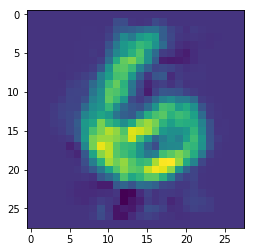

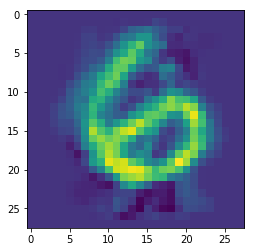

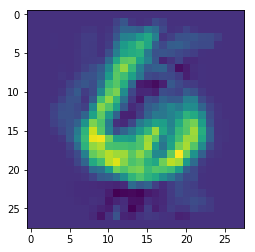

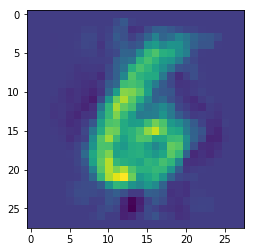

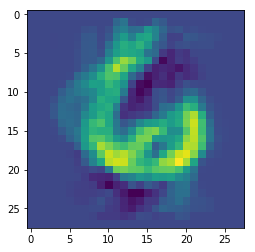

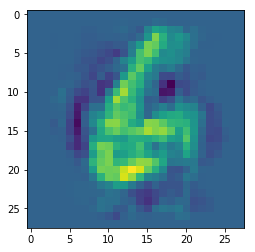

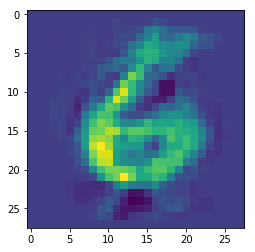

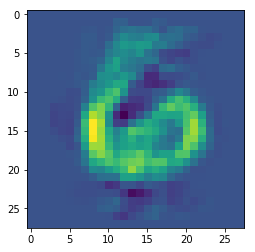

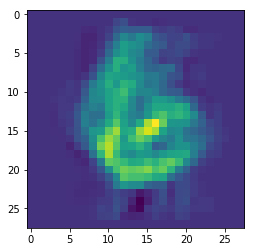

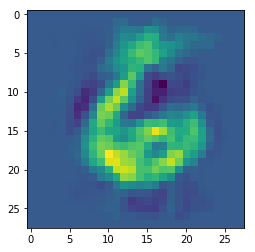

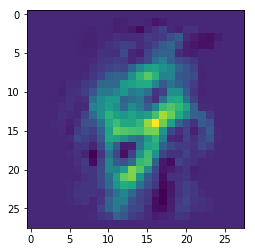

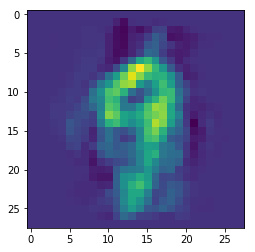

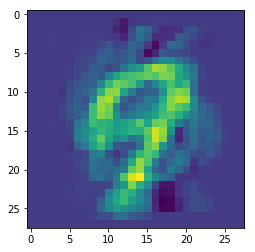

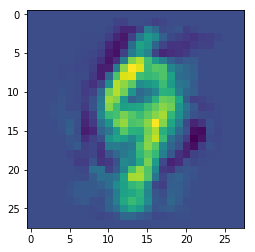

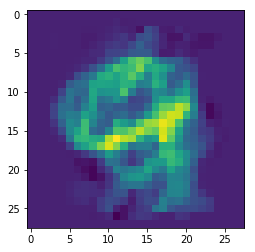

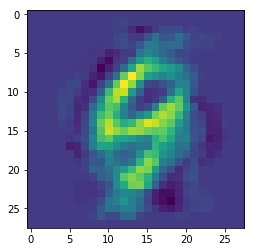

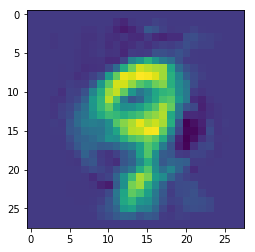

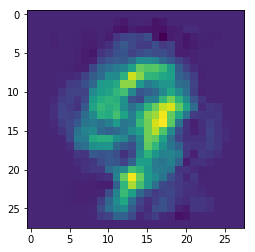

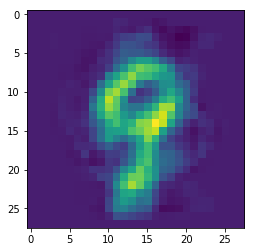

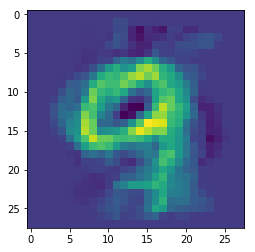

In [7]:
X, X_1 = exercise_1(True)

When pre-processing the data, we make sure that we did not shuffle the data. By doing this we know the ground truth of the images. So we know that the first 10 images should be a six and the other images should be nines.

As can be seen in the visualisation above, we could say that the reconstruction of the input is accurate enough to classify the image as being a 6 or a 9.

The function $exercise\_1$ follows the guidelines given in the assignment.

# Exercise 2

In [14]:
def exercise_2(plot=False):
	raw = loadmat("69dataset.mat")

	Y = raw['Y']
	X = raw['X']
	X_prior = raw['prior']

	[X, X_mean, X_std] = handcrafted_norm(X)
	[Y, _, _] = handcrafted_norm(Y)
	[X_prior, X_prior_mean, X_prior_std] = handcrafted_norm(X_prior)

	X_train, X_test, Y_train, Y_test = split_data(X, Y, shuffle=False)

	reg = Ridge(alpha=10 ** -6)
	reg.fit(X_train, Y_train)

	sigma_prior = np.dot(X_prior.T, X_prior) / (len(X_prior) - 1)
	sigma_prior = sigma_prior + np.multiply(np.identity(len(sigma_prior)), 10**-6)  # regularization
	sigma = np.multiply(np.identity(reg.coef_.shape[0]), 10**-3)

	if plot:
		plt.imshow(sigma_prior.transpose())
		plt.title(r"The covariance matrix of the $\Sigma_{prior}$")
		plt.colorbar()
		plt.show()

	sigma_inv = np.linalg.inv(sigma)
	
	u_post = np.linalg.inv(sigma_prior)
	u_post = u_post + np.dot(np.dot(reg.coef_.T, sigma_inv), reg.coef_)
	u_post = np.linalg.inv(u_post)
	u_post = np.dot(u_post, reg.coef_.T)
	u_post = np.dot(u_post, sigma_inv)

	res = np.array([np.dot(u_post, y) for y in Y_test])
	res = (res * X_std) + X_mean

# 	if plot:
# 		for i in range(len(res)):
# 			show_image(res, i)

	return res


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


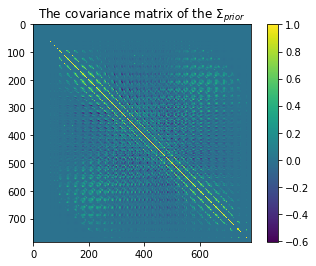

In [15]:
X2 = exercise_2(True)

In the covariance matrix, we can see that there is correlation between pixels that are close together in the image. Where a higher correlation corresponds to a brighter. The bright yellow line over the diagonal is because of the regularization and because the correlation of a pixel with iself is 1. Resulting in a symetric image of the diagonal.

In the plot you can see four blobs of high correlations. This is due to the differences between the images of a 9 vs. 6.

The dashed lines that can be seen in the plot are caused by the structure of the images of the digits. The image of the digits only have contents to the middle of the image, resulting in a correlation of 0 at the edges of the image.

# A comparison of the methods

In [16]:
def compare(X, X1, X2):
	for i in range(X1.shape[0]):
		plt.subplot(131).set_title("Real Image")
		plt.imshow(np.reshape(X[i], newshape=[28, 28]).transpose())
		plt.subplot(132).set_title("Ridge Regression")
		plt.imshow(np.reshape(X1[i], newshape=[28, 28]).transpose())
		plt.subplot(133).set_title("Bayes")
		plt.imshow(np.reshape(X2[i], newshape=[28, 28]).transpose())
		plt.show()

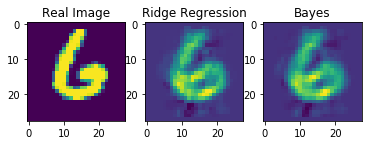

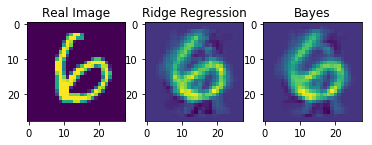

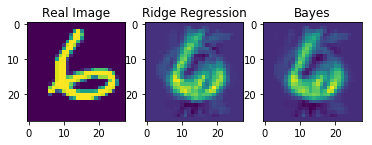

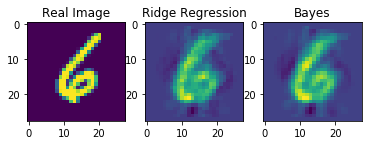

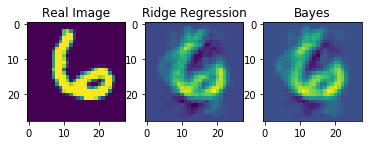

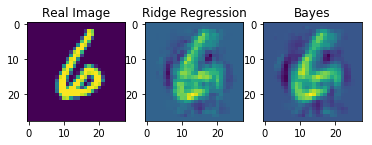

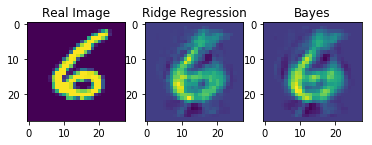

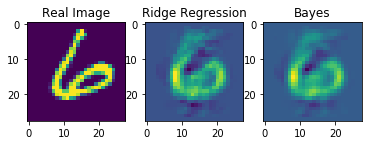

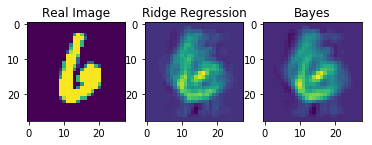

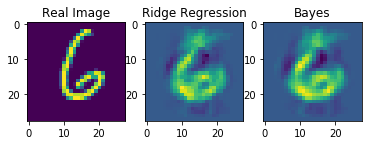

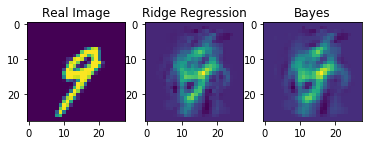

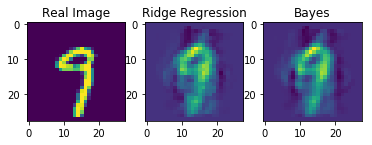

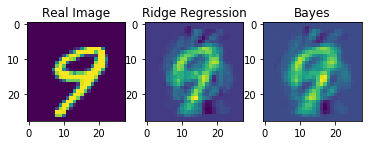

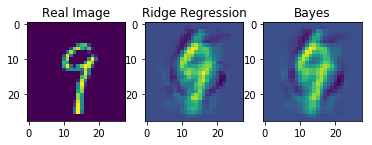

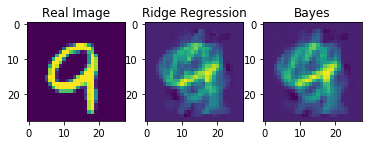

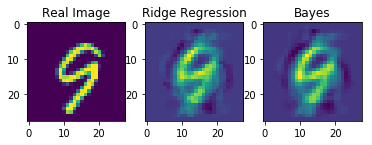

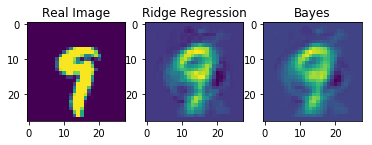

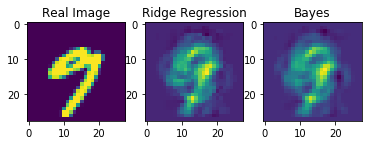

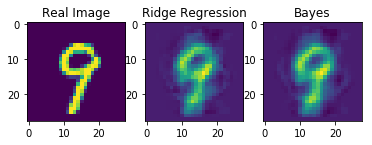

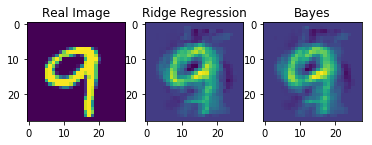

In [17]:
compare(X, X_1, X2)

We can see that both methods have a lot of noise in the predicted images, although we can see what number it should represent. 

There is almost no difference between both predictions, only the darkness of the background of the images is slightly different.

A way to use Neural Networks to improve this result is being using convolutional and max-pooling layers to detect specific feautures in the brain data. The problem with this approach is that we would need more data than we have available right now. That is if we want to use genuine data, instead of marginally transforming the images.

Another approach might be to use the dimensionality of time in combination with a Recurrent Neural Network. However, this would change the question that you want to examine.